# Initial Cell Condition Generator Notebook

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import random
from math import sqrt, pi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Cell Initializer Class

In [6]:
class CellInitializer:
    def __init__(self, x_min, x_max, y_min, y_max):
        """
        Initializes the cell initializer with dimensions and cell types.

        Args:
            x_min: Minimum x-coordinate of the grid.
            x_max: Maximum x-coordinate of the grid.
            y_min: Minimum y-coordinate of the grid.
            y_max: Maximum y-coordinate of the grid.
        """
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.grid_width = x_max - x_min
        self.grid_height = y_max - y_min

        # Create the grid, which will be centered around (0, 0)
        self.grid = np.zeros((self.grid_height, self.grid_width), dtype=int) 
        self.cell_types = {}
        self.n_cell_types = 0
        self.cell_type_mapping = {}
        
    def _update_cell_types(self, cell_type, cell_type_radius):
        """
        Updates the internal dictionary of cell types and their mappings for grid placement.
        """
        self.cell_types[cell_type] = {'radius':cell_type_radius}
        self.n_cell_types = self.n_cell_types + 1
        self.cell_type_mapping[cell_type] = self.n_cell_types

    def place_cells(self, cell_type, num_cells, cell_type_radius=13, layout="box", pattern="random",
                     box_width=100, box_height=100, circle_radius=50, ring_inner_radius=20, ring_outer_radius=50,
                     box_top_left_x=0, box_top_left_y=0, circle_center_x=None, circle_center_y=None):
        """
        Places cells based on the specified layout and pattern.

        Args:
            cell_type: The type of cell to place.
            num_cells: The number of cells to place.  **This argument is ignored when pattern="honeycomb"**
            cell_type_radius: The radius of the cell type.
            layout: The layout for cell placement ('box', 'circle', 'ring'). Default: 'box'.
            pattern: The spatial pattern of cells within the layout ('random', 'honeycomb'). Default: 'random'.
            box_width: Width of the box layout. Default: 100.
            box_height: Height of the box layout. Default: 100.
            circle_radius: Radius of the circle layout. Default: 50.
            ring_inner_radius: Inner radius of the ring layout. Default: 20.
            ring_outer_radius: Outer radius of the ring layout. Default: 50.
            box_top_left_x: X-coordinate of the top left corner of the box. Default: 0.
            box_top_left_y: Y-coordinate of the top left corner of the box. Default: 0.
            circle_center_x: X-coordinate of the center of the circle. Default: None (center of the grid).
            circle_center_y: Y-coordinate of the center of the circle. Default: None (center of the grid).
        """

        if cell_type not in set(self.cell_types):
            self._update_cell_types(cell_type, cell_type_radius)

        if layout == "box":
            if pattern == "honeycomb":
                print("WARNING: 'num_cells' argument is ignored for honeycomb pattern. The box will be fully populated with the indicated cell type.")
                self._place_cells_honeycomb_box(cell_type, box_width, box_height, box_top_left_x, box_top_left_y)
            else:
                self._place_cells_box(cell_type, num_cells, pattern, box_width, box_height, box_top_left_x, box_top_left_y)
        elif layout == "circle":
            if circle_center_x is None:
                circle_center_x = 0  # Center of the grid
            if circle_center_y is None:
                circle_center_y = 0  # Center of the grid
            if pattern == "honeycomb":
                print("WARNING: 'num_cells' argument is ignored for honeycomb pattern. The circle will be fully populated with the indicated cell type.")
                self._place_cells_honeycomb_circle(cell_type, circle_radius, circle_center_x, circle_center_y)
            else:
                self._place_cells_circle(cell_type, num_cells, pattern, circle_radius, circle_center_x, circle_center_y)
        elif layout == "ring":
            if circle_center_x is None:
                circle_center_x = 0  # Center of the grid
            if circle_center_y is None:
                circle_center_y = 0  # Center of the grid
            if pattern == "honeycomb":
                print("WARNING: 'num_cells' argument is ignored for honeycomb pattern. The ring will be fully populated with the indicated cell type.")
                self._place_cells_honeycomb_ring(cell_type, ring_inner_radius, ring_outer_radius, circle_center_x, circle_center_y)
            else:
                self._place_cells_ring(cell_type, num_cells, pattern, ring_inner_radius, ring_outer_radius, circle_center_x, circle_center_y)
        else:
            raise ValueError("Invalid layout. Must be 'box', 'circle', or 'ring'.")

    def _place_cells_honeycomb_box(self, cell_type, box_width, box_height, box_top_left_x=0, box_top_left_y=0):
        """
        Places cells in a honeycomb pattern within a box layout using hexagon close-packing.
        """
        radius = self.cell_types[cell_type]['radius']
        grid_size = self.grid_width

        # Calculate bounding box for honeycomb in grid coordinates
        box_x_min = max(0, int(box_top_left_x - box_width * sqrt(3) / 2 - radius))
        box_x_max = min(self.grid_width, int(box_top_left_x + box_width * sqrt(3) / 2 + radius))
        box_y_min = max(0, int(box_top_left_y - 3 * radius / 2))
        box_y_max = min(self.grid_height, int(box_top_left_y + box_height * 3 / 2 + 3 * radius / 2))

        # Generate honeycomb grid positions within the bounding box
        x_coords = np.arange(box_x_min, box_x_max)
        y_coords = np.arange(box_y_min, box_y_max)
        X, Y = np.meshgrid(x_coords, y_coords)

        # Calculate hexagonal lattice distances
        distances_x = X + self.x_min - box_top_left_x - radius * sqrt(3) / 2
        distances_y = Y + self.y_min - box_top_left_y

        # Check if each position is within the hexagon and unoccupied
        valid_positions = np.where(
            (distances_x % (radius * sqrt(3)) < radius * sqrt(3) / 2) 
            & (distances_y % (3 * radius / 2) < 3 * radius / 4)
            & (self.grid[Y, X] == 0) 
        )

        # Place cells at the valid positions
        self.grid[valid_positions[1], valid_positions[0]] = self.cell_type_mapping[cell_type]

    def _place_cells_honeycomb_circle(self, cell_type, circle_radius, circle_center_x=0, circle_center_y=0):
        """
        Places cells in a honeycomb pattern within a circle layout using hexagon close-packing.
        """
        radius = self.cell_types[cell_type]['radius']
        grid_size = self.grid_width

        # Calculate bounding box for honeycomb in grid coordinates
        box_x_min = max(0, int(circle_center_x - circle_radius - radius))
        box_x_max = min(self.grid_width, int(circle_center_x + circle_radius + radius))
        box_y_min = max(0, int(circle_center_y - circle_radius - 3 * radius / 2))
        box_y_max = min(self.grid_height, int(circle_center_y + circle_radius + 3 * radius / 2))

        # Generate honeycomb grid positions within the bounding box
        x_coords = np.arange(box_x_min, box_x_max)
        y_coords = np.arange(box_y_min, box_y_max)
        X, Y = np.meshgrid(x_coords, y_coords)

        # Calculate hexagonal lattice distances
        distances_x = X + self.x_min - circle_center_x - radius * sqrt(3) / 2
        distances_y = Y + self.y_min - circle_center_y

        # Check if each position is within the hexagon and unoccupied
        valid_positions = np.where(
            (distances_x % (radius * sqrt(3)) < radius * sqrt(3) / 2) 
            & (distances_y % (3 * radius / 2) < 3 * radius / 4)
            & (self.grid[Y, X] == 0)
            & (np.sqrt((X + self.x_min - circle_center_x)**2 + (Y + self.y_min - circle_center_y)**2) <= circle_radius)
        )

        # Place cells at the valid positions
        self.grid[valid_positions[1], valid_positions[0]] = self.cell_type_mapping[cell_type]

    def _place_cells_honeycomb_ring(self, cell_type, ring_inner_radius, ring_outer_radius, circle_center_x=0, circle_center_y=0):
        """
        Places cells in a honeycomb pattern within a ring layout using hexagon close-packing.
        """
        radius = self.cell_types[cell_type]['radius']
        grid_size = self.grid_width

        # Calculate bounding box for honeycomb in grid coordinates
        box_x_min = max(0, int(circle_center_x - ring_outer_radius - radius))
        box_x_max = min(self.grid_width, int(circle_center_x + ring_outer_radius + radius))
        box_y_min = max(0, int(circle_center_y - ring_outer_radius - 3 * radius / 2))
        box_y_max = min(self.grid_height, int(circle_center_y + ring_outer_radius + 3 * radius / 2))

        # Generate honeycomb grid positions within the bounding box
        x_coords = np.arange(box_x_min, box_x_max)
        y_coords = np.arange(box_y_min, box_y_max)
        X, Y = np.meshgrid(x_coords, y_coords)

        # Calculate hexagonal lattice distances
        distances_x = X + self.x_min - circle_center_x - radius * sqrt(3) / 2
        distances_y = Y + self.y_min - circle_center_y

        # Check if each position is within the hexagon and unoccupied
        valid_positions = np.where(
            (distances_x % (radius * sqrt(3)) < radius * sqrt(3) / 2) 
            & (distances_y % (3 * radius / 2) < 3 * radius / 4)
            & (self.grid[Y, X] == 0)
            & (np.sqrt((X + self.x_min - circle_center_x)**2 + (Y + self.y_min - circle_center_y)**2) >= ring_inner_radius)
            & (np.sqrt((X + self.x_min - circle_center_x)**2 + (Y + self.y_min - circle_center_y)**2) <= ring_outer_radius)
        )

        # Place cells at the valid positions
        self.grid[valid_positions[1], valid_positions[0]] = self.cell_type_mapping[cell_type]

    def _place_cells_box(self, cell_type, num_cells, pattern="random", box_width=100, box_height=100, box_top_left_x=0, box_top_left_y=0):
        """
        Places cells within a box layout.
        """
        if pattern == "honeycomb":
            self._place_cells_honeycomb(cell_type, box_width, box_height, box_top_left_x, box_top_left_y)
        else:
            for _ in range(num_cells):
                while True:
                    # Adjust coordinates to fit within the grid
                    x = random.randint(box_top_left_x, box_top_left_x + box_width - 1)
                    y = random.randint(box_top_left_y, box_top_left_y + box_height - 1)
                    x_grid_index = x - self.x_min
                    y_grid_index = y - self.y_min
                    if 0 <= x_grid_index < self.grid_width and 0 <= y_grid_index < self.grid_height:
                        if self.grid[y_grid_index, x_grid_index] == 0:
                            self.grid[y_grid_index, x_grid_index] = self.cell_type_mapping[cell_type]
                            break
                        else:
                            continue
                    else:
                        continue

    def _place_cells_circle(self, cell_type, num_cells, pattern="random", circle_radius=50, circle_center_x=0, circle_center_y=0):
        """
        Places cells within a circle layout.
        """
        if pattern == "honeycomb":
            raise ValueError("Honeycomb pattern not supported for circle layout.")
        else:
            for _ in range(num_cells):
                while True:
                    x = random.randint(self.x_min, self.x_max - 1)
                    y = random.randint(self.y_min, self.y_max - 1)
                    x_grid_index = x - self.x_min
                    y_grid_index = y - self.y_min
                    distance = sqrt((x - circle_center_x)**2 + (y - circle_center_y)**2)
                    if distance <= circle_radius:
                        if 0 <= x_grid_index < self.grid_width and 0 <= y_grid_index < self.grid_height:
                            if self.grid[y_grid_index, x_grid_index] == 0:
                                self.grid[y_grid_index, x_grid_index] = self.cell_type_mapping[cell_type]
                                break
                            else:
                                continue
                        else:
                            continue
                    else:
                        continue

    def _place_cells_ring(self, cell_type, num_cells, pattern="random", ring_inner_radius=20, ring_outer_radius=50, circle_center_x=0, circle_center_y=0):
        """
        Places cells within a ring layout.
        """
        if pattern == "honeycomb":
            raise ValueError("Honeycomb pattern not supported for ring layout.")
        else:
            for _ in range(num_cells):
                while True:
                    x = random.randint(self.x_min, self.x_max - 1)
                    y = random.randint(self.y_min, self.y_max - 1)
                    x_grid_index = x - self.x_min
                    y_grid_index = y - self.y_min
                    distance = sqrt((x - circle_center_x)**2 + (y - circle_center_y)**2)
                    if distance >= ring_inner_radius and distance <= ring_outer_radius:
                        if 0 <= x_grid_index < self.grid_width and 0 <= y_grid_index < self.grid_height:
                            if self.grid[y_grid_index, x_grid_index] == 0:
                                self.grid[y_grid_index, x_grid_index] = self.cell_type_mapping[cell_type]
                                break
                            else:
                                continue
                        else:
                            continue
                    else:
                        continue

    def to_dataframe(self):
        """
        Converts the cell grid to a pandas DataFrame.
        """
        cell_types = list(self.cell_types.keys())
        cell_locations = []
        for y in range(self.grid_height):
            for x in range(self.grid_width):
                if self.grid[y, x] != 0:
                    cell_locations.append([x + self.x_min, y + self.y_min, 0, cell_types[self.grid[y, x]-1]])

        df = pd.DataFrame(cell_locations, columns=['x', 'y', 'z', 'type'])
        return df

    def to_csv(self, filename):
        """
        Saves the cell grid to a CSV file.
        """
        df = self.to_dataframe()
        df.to_csv(filename, index=False)

    def visualize_grid(self, legend=True):
        """
        Visualizes the cell grid using Matplotlib.
        """
        leg_handles = []
        leg_labels = []
        fig, ax = plt.subplots()
        for cell_type, cell_idx in self.cell_type_mapping.items():
            # Find the coordinates of cells of this type
            cell_coords = np.argwhere(self.grid == cell_idx)
            for coord in cell_coords:
                radius = self.cell_types[cell_type]['radius']
                circle = plt.Circle((coord[1] + self.x_min, coord[0] + self.y_min), radius, color=plt.cm.tab10(cell_idx), fill=True)  # Plot circle at (y,x)
                ax.add_patch(circle)
            if cell_type not in leg_labels:
                cell_patch = mpatches.Patch(color=plt.cm.tab10(cell_idx), label = cell_type)
                leg_handles.append(cell_patch)
                leg_labels.append(cell_type)
        if legend: 
            ax.legend(handles=leg_handles)
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.title("Cell Grid Visualization (2D)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis('equal')
        plt.show()

def get_hex_coordinates(cell_idx, radius, offset):
    # Use a hexagonal lattice pattern
    row = cell_idx // (2 * radius + 1)  # Number of rows
    col = cell_idx - row * (2 * radius + 1)  # Number of columns
    x = radius * sqrt(3) * col + (radius * sqrt(3) / 2) * row
    y = radius * 3 / 2 * row
    return x, y

### Testing Cell Initializer Class for Spheroid Generation

In [10]:
# instantiate ics
initializer = CellInitializer(x_min=-1000, x_max=1000, y_min=-1000, y_max=1000)

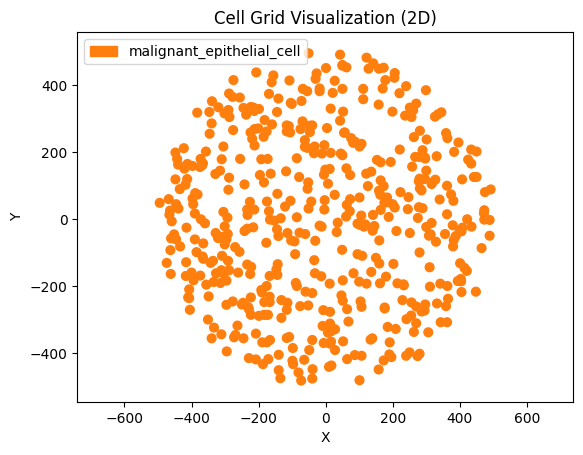

In [11]:
# Place 50 M0_macrophages in a circle layout with random pattern
initializer.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=500, 
    layout="circle", 
    pattern="random", 
    circle_radius=500)
initializer.visualize_grid()

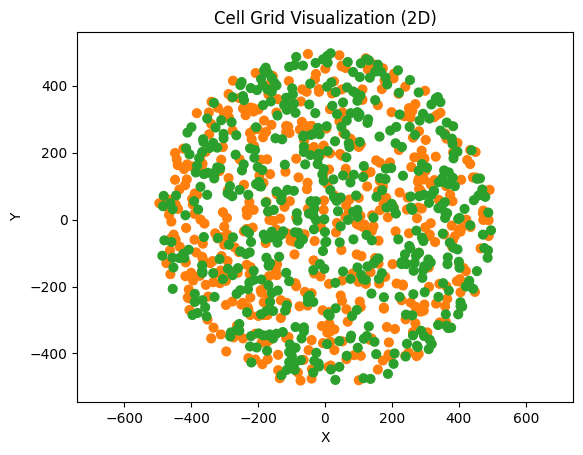

In [12]:
# Place 50 tumor cells in a box layout with random pattern
initializer.place_cells(
    cell_type="fibroblast", 
    num_cells=500, 
    layout="circle", 
    pattern="random", 
    circle_radius=500)
initializer.visualize_grid(legend=False)

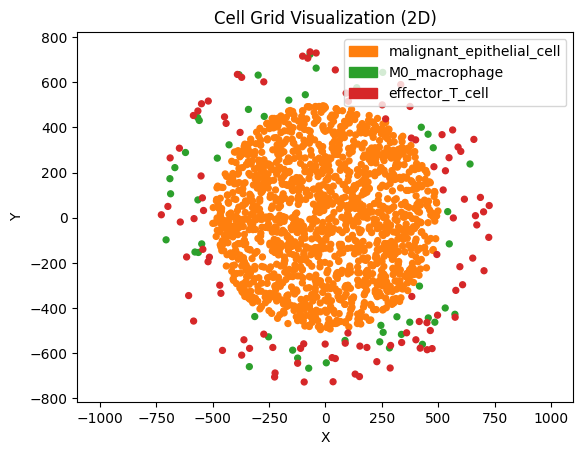

In [24]:
# Place 100 effector T cells in a ring layout with random pattern
initializer.place_cells(
    cell_type="effector_T_cell", 
    num_cells=100, 
    layout="ring", 
    pattern="random",
    ring_inner_radius=510,
    ring_outer_radius=750,
)
initializer.visualize_grid()

In [62]:
cell_df = initializer.to_dataframe()

In [63]:
cell_df

,x,y,z,type
0,91,-727,0,M0_macrophage
1,-153,-723,0,M0_macrophage
2,-267,-699,0,M0_macrophage
3,-247,-692,0,M0_macrophage
4,8,-692,0,effector_T_cell
...,...,...,...,...
1645,2,701,0,M0_macrophage
1646,-147,702,0,effector_T_cell
1647,-17,708,0,effector_T_cell
1648,-100,713,0,M0_macrophage


In [64]:
cell_df.to_csv("../../misc/testing_cells.csv", index=False)

## Other Functionality Testing

In [51]:
# instantiate ics
initializer = CellInitializer(x_min=-500, x_max=500, y_min=-500, y_max=500)

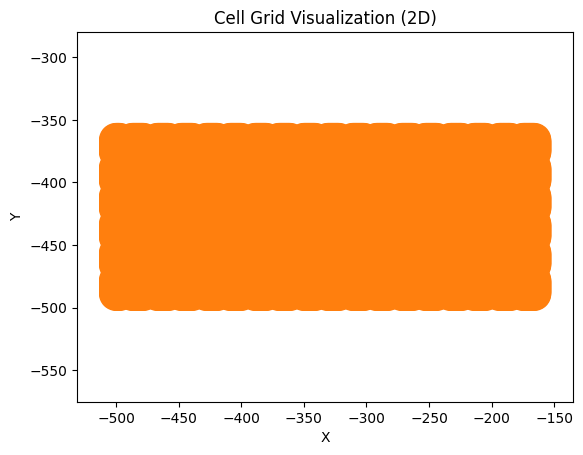

In [52]:
# Place 50 tumor cells in a box layout with random pattern
initializer.place_cells(
    cell_type="effector_T_cell", 
    layout="box", 
    pattern="honeycomb",
    num_cells=100,
    box_top_left_x=-50,
    box_top_left_y=50,
    box_width=200,
    box_height=200
)
initializer.visualize_grid()

In [53]:
initializer.to_dataframe()

,x,y,z,type
0,-500,-489,0,1
1,-499,-489,0,1
2,-498,-489,0,1
3,-497,-489,0,1
4,-487,-489,0,1
...,...,...,...,...
12001,-170,-366,0,1
12002,-169,-366,0,1
12003,-168,-366,0,1
12004,-167,-366,0,1


### Example initial conditions

In [13]:
# instantiate ics
initializer2 = CellInitializer(x_min=-1000, x_max=1000, y_min=-1000, y_max=1000)

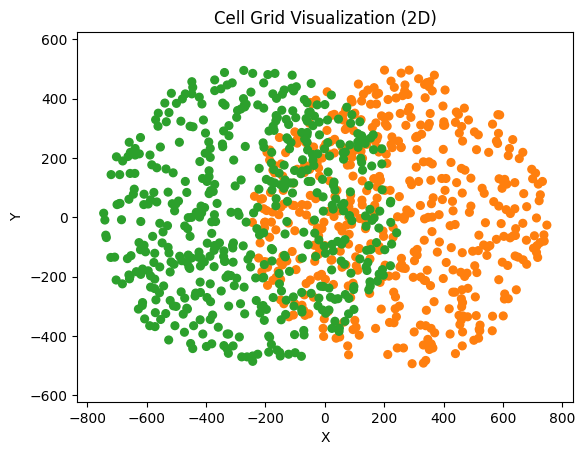

In [15]:
initializer2.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=500, 
    layout="circle", 
    pattern="random", 
    circle_radius=500,
    circle_center_x=250,
    circle_center_y=0
)
initializer2.place_cells(
    cell_type="fibroblast", 
    num_cells=500, 
    layout="circle", 
    pattern="random", 
    circle_radius=500,
    circle_center_x=-250,
    circle_center_y=0
)
initializer2.visualize_grid(legend=False)

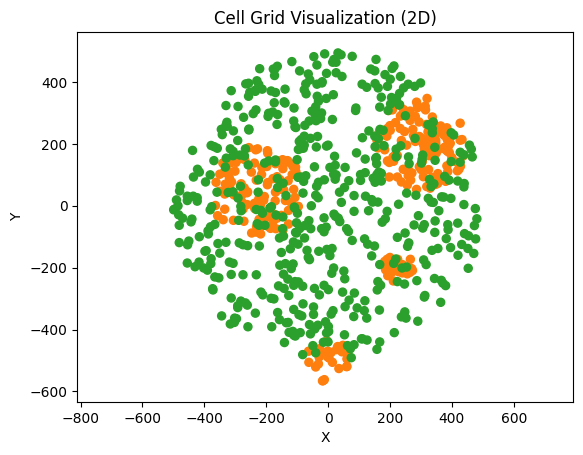

In [21]:
initializer3 = CellInitializer(x_min=-1000, x_max=1000, y_min=-1000, y_max=1000)
initializer3.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=100, 
    layout="circle", 
    pattern="random", 
    circle_radius=150,
    circle_center_x=300,
    circle_center_y=200
)
initializer3.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=100, 
    layout="circle", 
    pattern="random", 
    circle_radius=150,
    circle_center_x=-230,
    circle_center_y=45
)
initializer3.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=25, 
    layout="circle", 
    pattern="random", 
    circle_radius=50,
    circle_center_x=350,
    circle_center_y=210
)
initializer3.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=25, 
    layout="circle", 
    pattern="random", 
    circle_radius=50,
    circle_center_x=225,
    circle_center_y=-200
)
initializer3.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=25, 
    layout="circle", 
    pattern="random", 
    circle_radius=70,
    circle_center_x=0,
    circle_center_y=-500
)
initializer3.place_cells(
    cell_type="fibroblast", 
    num_cells=500, 
    layout="circle", 
    pattern="random", 
    circle_radius=500,
    circle_center_x=0,
    circle_center_y=0
)
initializer3.visualize_grid(legend=False)

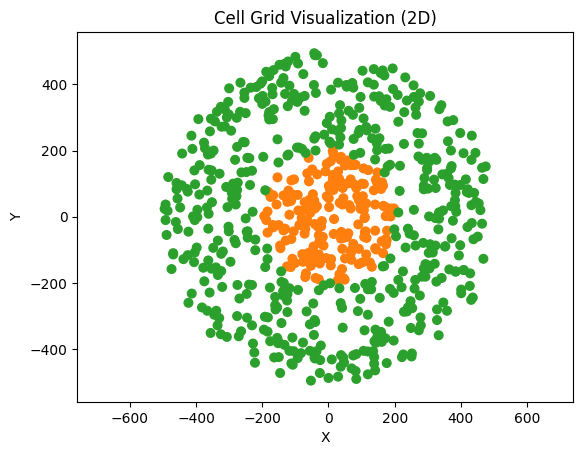

In [22]:
initializer4 = CellInitializer(x_min=-1000, x_max=1000, y_min=-1000, y_max=1000)
initializer4.place_cells(
    cell_type="malignant_epithelial_cell", 
    num_cells=200, 
    layout="circle", 
    pattern="random", 
    circle_radius=200,
    circle_center_x=0,
    circle_center_y=0
)
initializer4.place_cells(
    cell_type="fibroblast", 
    num_cells=500, 
    layout="ring", 
    pattern="random", 
    ring_inner_radius=200,
    ring_outer_radius=500,
    circle_center_x=0,
    circle_center_y=0
)
initializer4.visualize_grid(legend=False)